<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 28 02:38:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             53W /  400W |     561MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [3]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
from google.colab import files
uploaded = files.upload()

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pynndescent 0.5.13 requires numba>=0.51.2, which is not installed.
keras-hub 0.18.1 requires tensorflow-text; platform_system != "Darwin", which is not installed.
tensorflow-hub 0.16.1 requires tf-keras>=2.14.1,

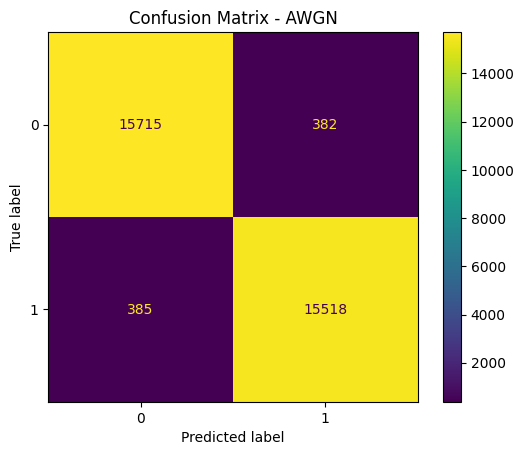

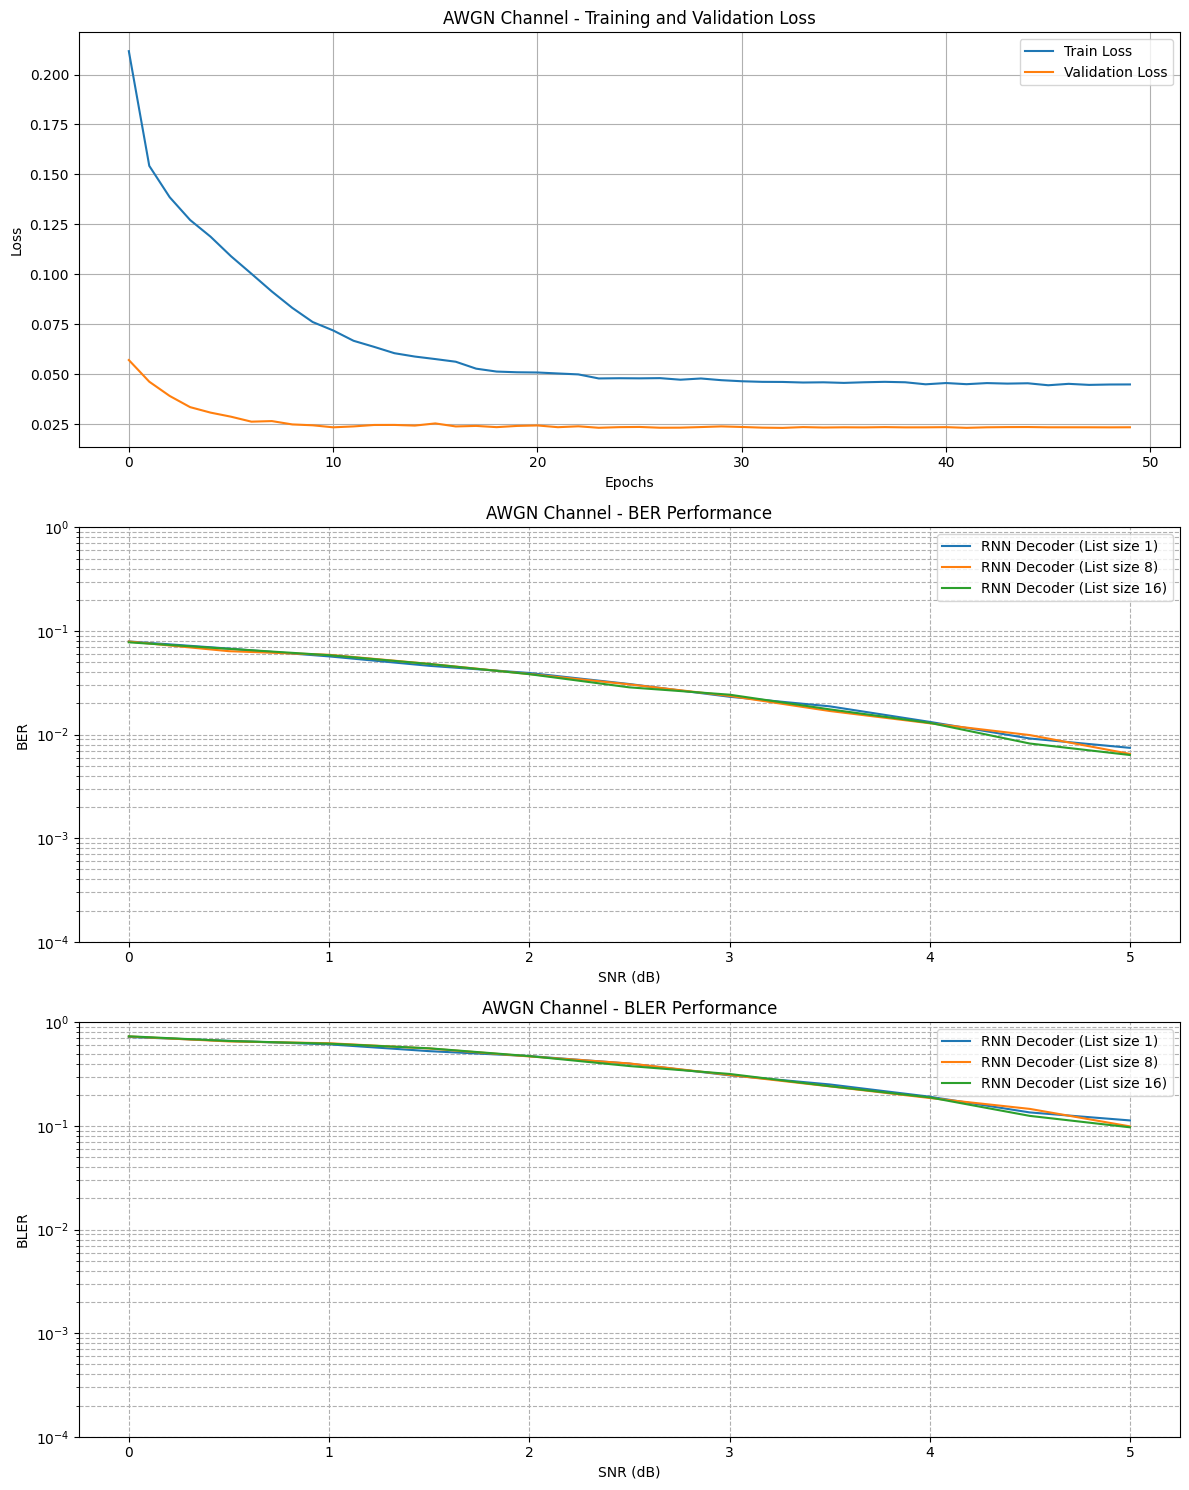

Epoch [1/50], Train Loss: 0.2995, Val Loss: 0.1555
Epoch [2/50], Train Loss: 0.2510, Val Loss: 0.1375
Epoch [3/50], Train Loss: 0.2308, Val Loss: 0.1209
Epoch [4/50], Train Loss: 0.2101, Val Loss: 0.1139
Epoch [5/50], Train Loss: 0.1920, Val Loss: 0.1043
Epoch [6/50], Train Loss: 0.1773, Val Loss: 0.1031
Epoch [7/50], Train Loss: 0.1669, Val Loss: 0.1019
Epoch [8/50], Train Loss: 0.1600, Val Loss: 0.1007
Epoch [9/50], Train Loss: 0.1546, Val Loss: 0.1000
Epoch [10/50], Train Loss: 0.1509, Val Loss: 0.0994
Epoch [11/50], Train Loss: 0.1488, Val Loss: 0.1005
Epoch [12/50], Train Loss: 0.1465, Val Loss: 0.0995
Epoch [13/50], Train Loss: 0.1450, Val Loss: 0.0983
Epoch [14/50], Train Loss: 0.1439, Val Loss: 0.0998
Epoch [15/50], Train Loss: 0.1419, Val Loss: 0.0989
Epoch [16/50], Train Loss: 0.1412, Val Loss: 0.0995
Epoch [17/50], Train Loss: 0.1402, Val Loss: 0.0997
Epoch [18/50], Train Loss: 0.1390, Val Loss: 0.0984
Epoch [19/50], Train Loss: 0.1388, Val Loss: 0.0981
Epoch [20/50], Train 

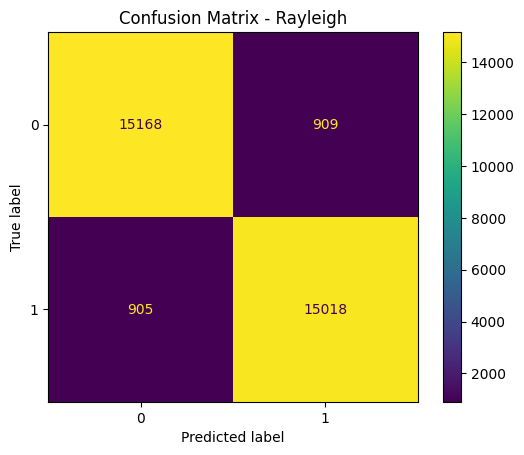

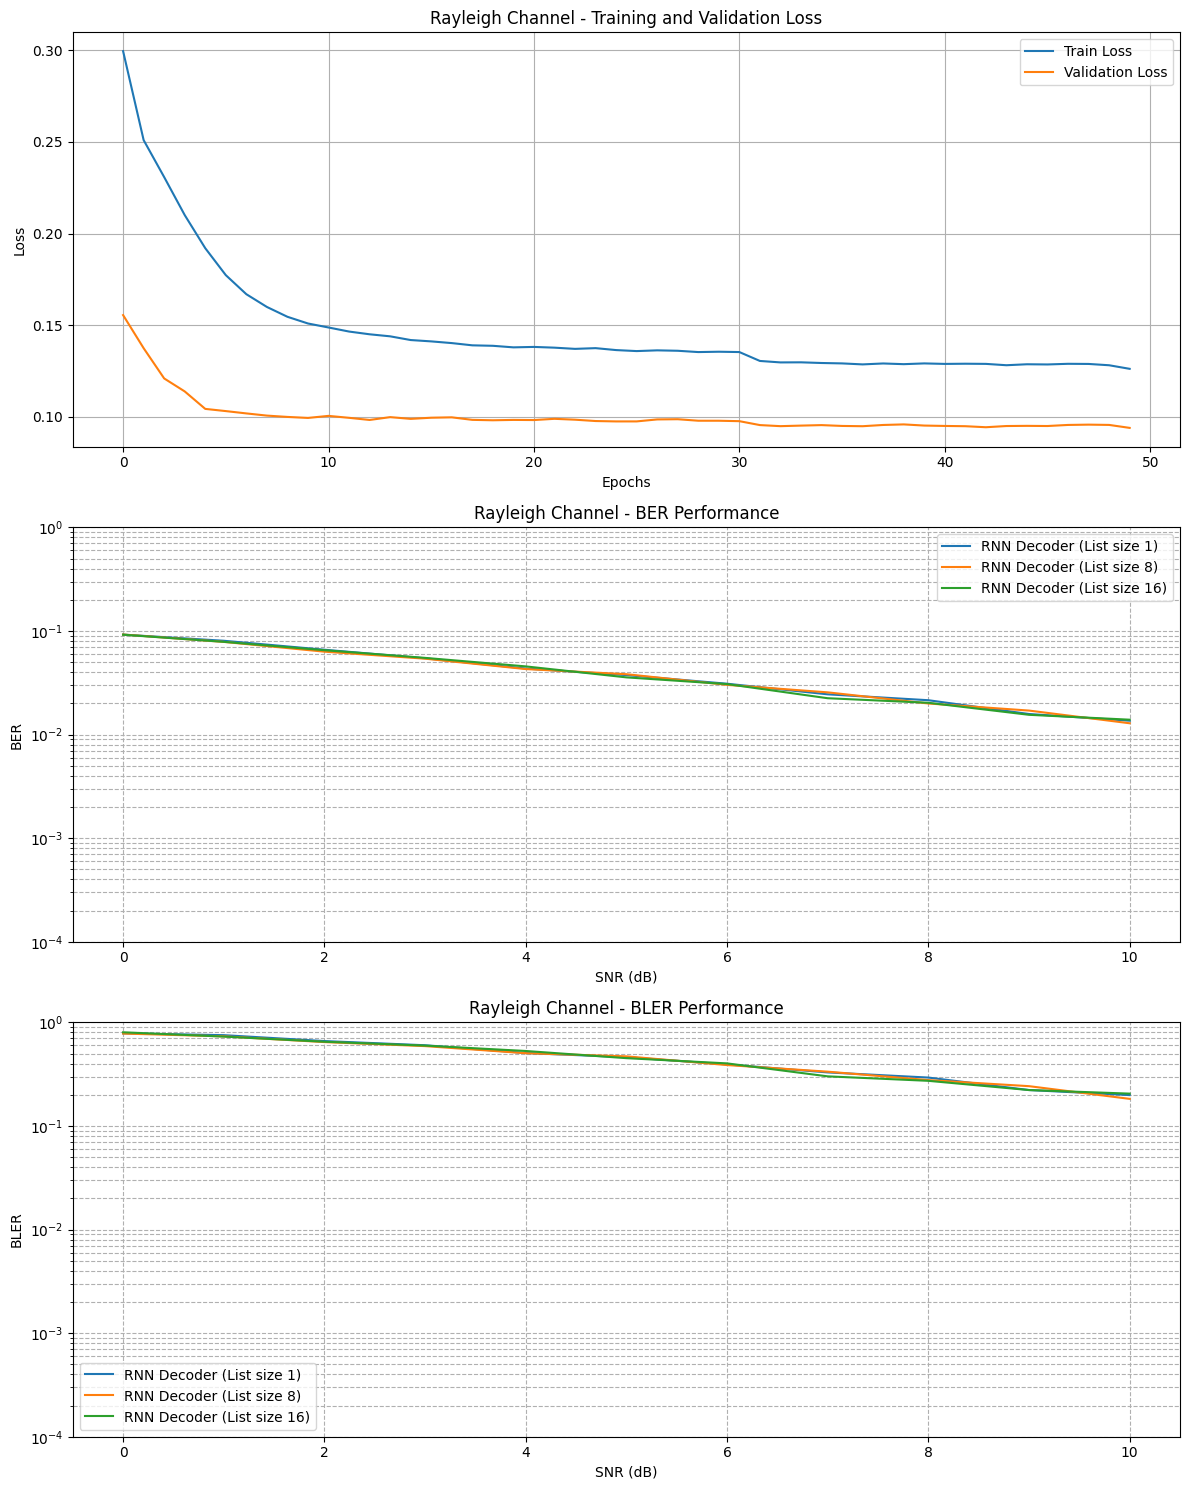

Streaming output truncated to the last 5000 lines.
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8.0
SNR (dB): 8

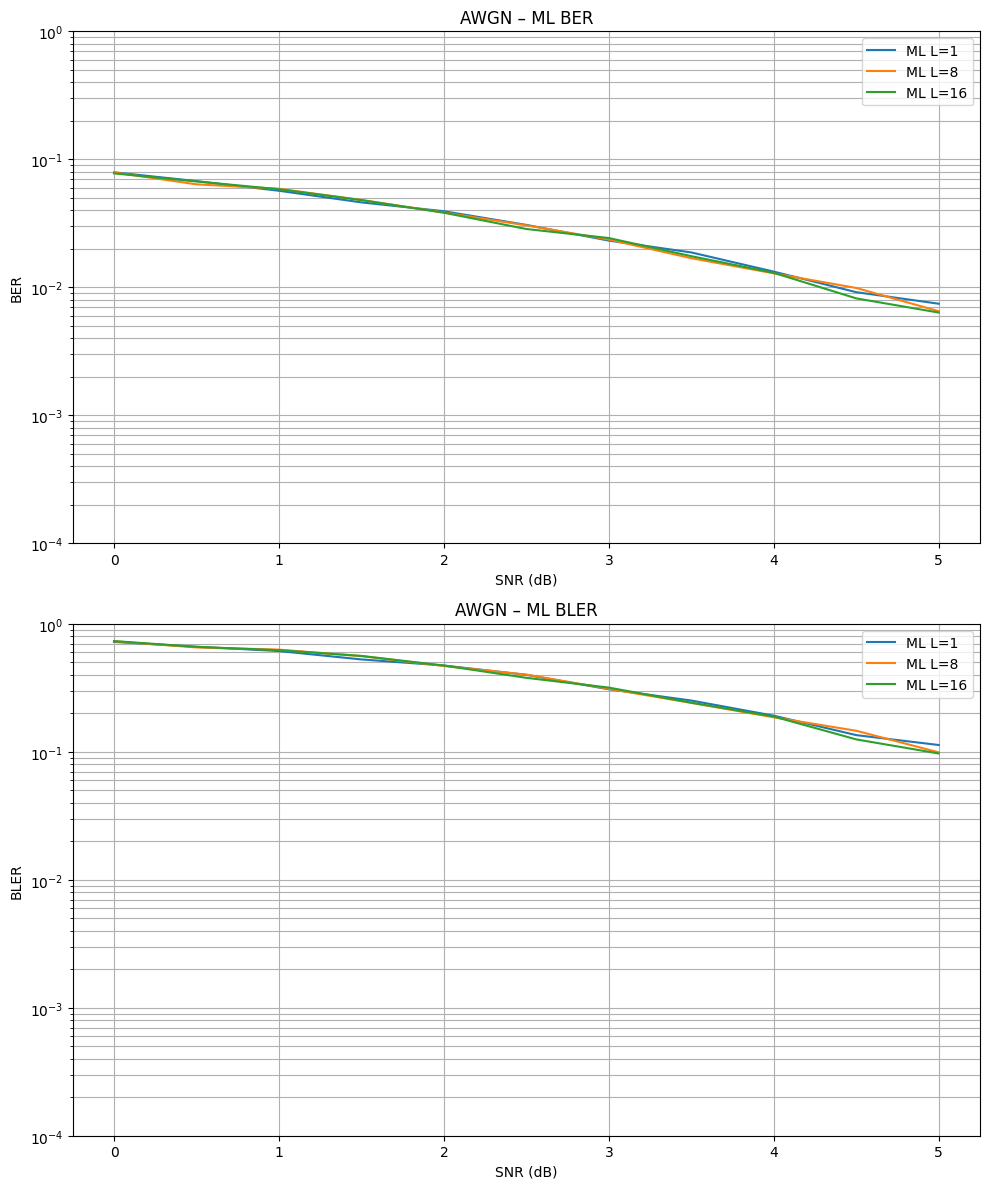

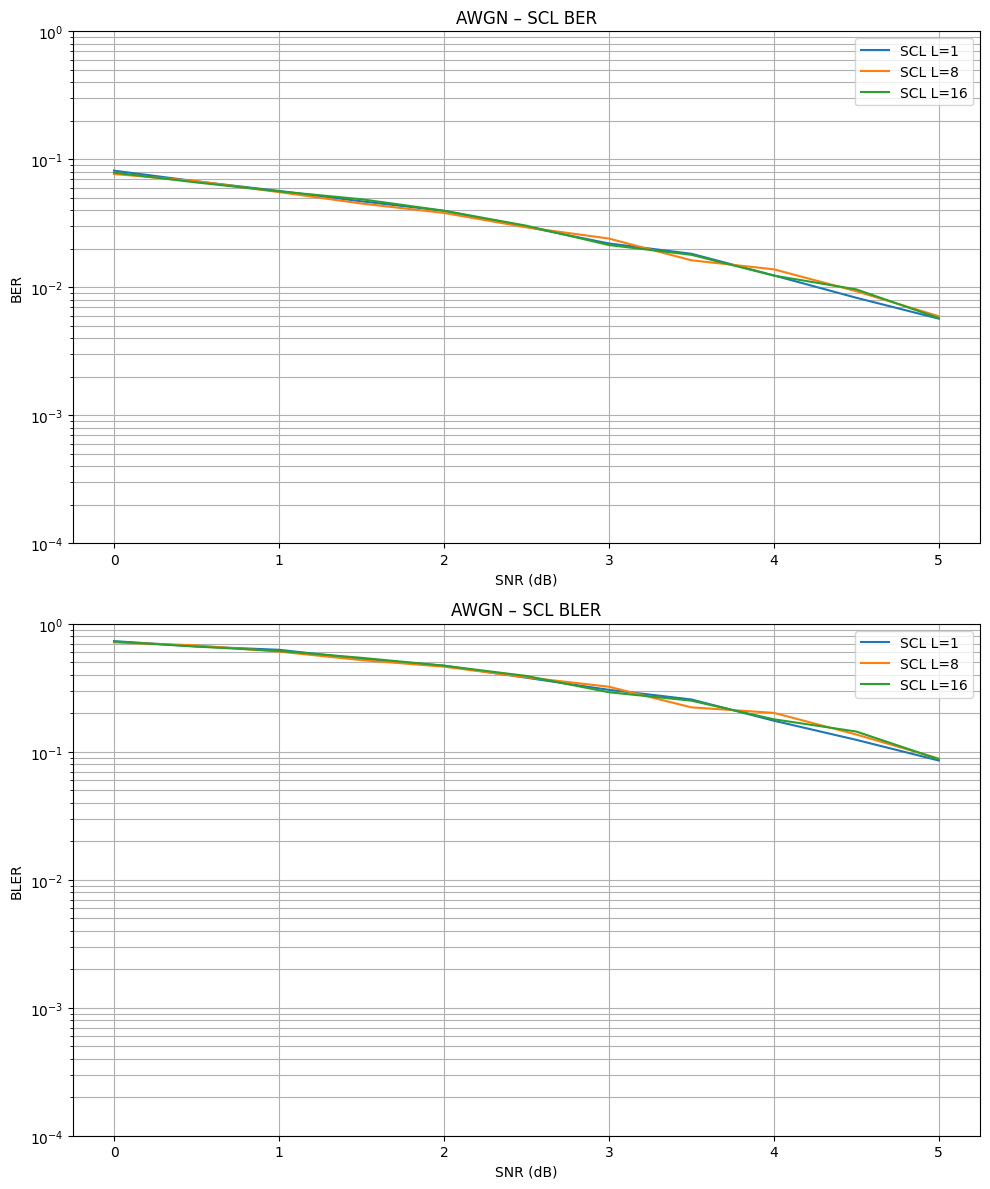

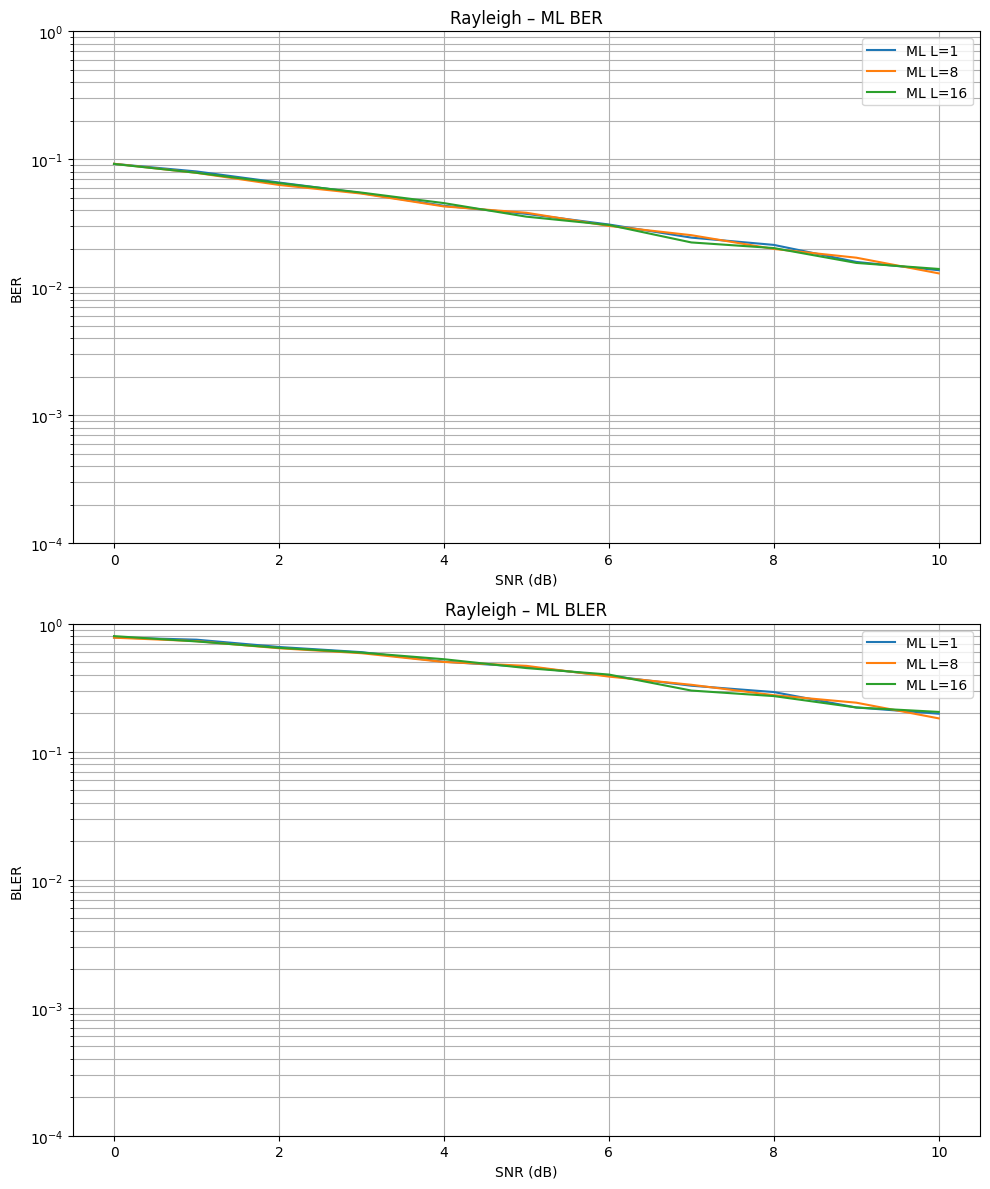

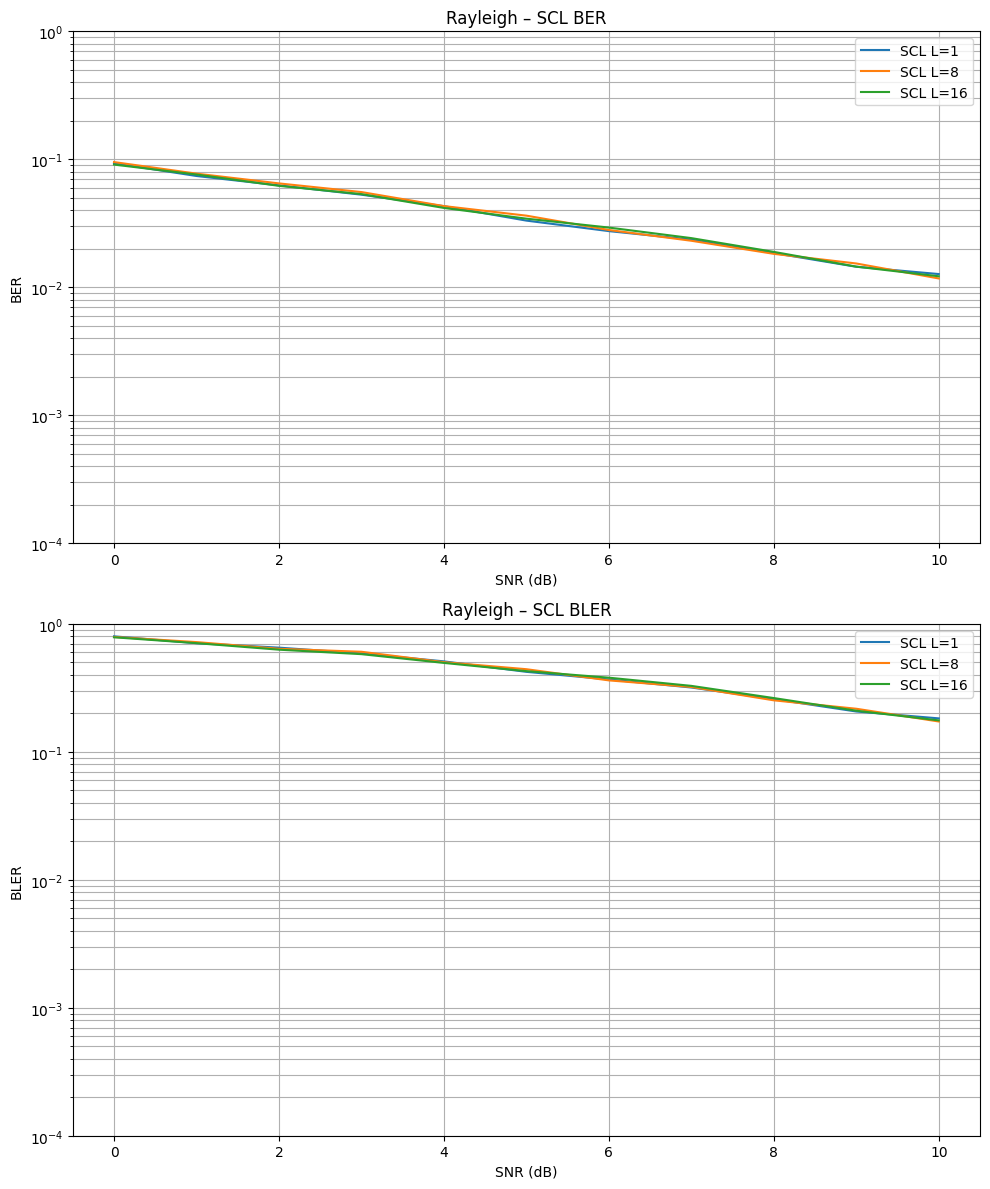

In [1]:
#latest plot functions
# Updates code script
# Comprehensive Polar Code Simulation Framework
# Clean up and install necessary libraries in one go
# This helps avoid potential conflicts from multiple installations
# Explicitly uninstall pandas and install a compatible version first
# Google Colab requires pandas==2.2.2 as of the last error message.
# Comprehensive Uninstall
#!pip list | grep -E "numpy|pandas|scipy|torch"
#!pip install numpy==1.24.4 pandas==1.5.3
#!pip install numpy==1.24.4 --no-cache-dir
#!pip install pandas==1.5.3 --no-cache-dir
!pip uninstall -y numpy pandas
!pip install numpy pandas
!pip uninstall -y torch torchvision torchaudio fastai numba tensorflow tensorflow-decision-forests tensorflow-text tf-keras numpy pandas scikit-learn scipy cuml-cu12 cudf-cu12 dask-cuda distributed-ucxx-cu12 ml-dtypes tensorboard dask-cudf-cu12 raft-dask-cu12 sklearn-pandas
!pip install --upgrade scipy
# Install core libraries with --upgrade to force versions
!pip install numpy==1.26.4 --upgrade --no-cache-dir
#!pip install scipy==1.14.0 --upgrade --no-cache-dir
!pip install pandas==2.2.2 --upgrade --no-cache-dir
#!pip install scikit-learn==1.4.1.post1 --upgrade --no-cache-dir
#!pip install sklearn-pandas==2.2.8 --upgrade --no-cache-dir
# Rest of your installations (commented out for this test)
# !pip install scipy==1.14.0 --no-cache-dir
# !pip install scikit-learn==1.4.1.post1 --no-cache-dir
# !pip install sklearn-pandas==2.2.8 --no-cache-dir # Explicitly install sklearn-pandas after pandas
# !pip install torch==2.6.0 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124 --no-cache-dir
# !pip install fastai==2.7.19 --no-cache-dir
# !pip install matplotlib --no-cache-dir
# !pip install tensorflow==2.18.0 tensorflow-decision-forests tensorflow-text tf-keras --no-cache-dir
# !pip install numba==0.60.0 --no-cache-dir
# Install other libraries with --upgrade
#!pip install torch==2.6.0 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124 --upgrade --no-cache-dir
#!pip install fastai==2.7.19 --upgrade --no-cache-dir
#!pip install matplotlib --upgrade --no-cache-dir
#!pip install tensorflow==2.18.0 tensorflow-decision-forests tensorflow-text tf-keras --upgrade --no-cache-dir
#!pip install numba==0.60.0 --upgrade --no-cache-dir
# Install other libraries, including Torch and its related packages
!pip install scipy==1.14.0 --no-cache-dir
!pip install scikit-learn==1.4.1.post1 --no-cache-dir
!pip install sklearn-pandas==2.2.8 --no-cache-dir # Explicitly install sklearn-pandas after pandas
!pip install torch==2.6.0 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124 --no-cache-dir
!pip install fastai==2.7.19 --no-cache-dir
!pip install matplotlib --no-cache-dir
!pip install tensorflow==2.18.0 tensorflow-decision-forests tensorflow-text tf-keras --no-cache-dir
!pip install numba==0.60.0 --no-cache-dir
# Install RAPIDS libraries if you need them, making sure to match versions and Numba/CUDA compatibility
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0 dask-cudf-cu12==25.2.2 raft-dask-cu12==25.2.0 --extra-index-url=https://pypi.nvidia.com --no-cache-dir
# Install RAPIDS libraries if you need them, making sure to match versions and Numba/CUDA compatibility
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0 dask-cudf-cu12==25.2.2 raft-dask-cu12==25.2.0 --extra-index-url=https://pypi.nvidia.com --upgrade --no-cache-dir
import logging
import numpy as np
import math # You'll likely need math functions like exp, log
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
# Essential Libraries - Import AFTER installation
import numpy as np
#import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.special as sps
import logging, traceback, sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.special as sps # Added for theoretical performance
import traceback # Added for error tracing
print(f"NumPy version: {np.__version__}")
#print(f"Pandas version: {pd.__version__}")
# Install RAPIDS libraries if you need them, making sure to match versions and Numba/CUDA compatibility
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0 dask-cudf-cu12==25.2.2 raft-dask-cu12==25.2.0 --extra-index-url=https://pypi.nvidia.com --no-cache-dir
# Install RAPIDS libraries if you need them, making sure to match versions and Numba/CUDA compatibility
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0 dask-cudf-cu12==25.2.2 raft-dask-cu12==25.2.0 --extra-index-url=https://pypi.nvidia.com --no-cache-dir
# You may need to install RAPIDS libraries separately if you are using them:
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0
# Now install/upgrade other essential libraries to potentially compatible versions
#!pip install -q --upgrade numpy matplotlib scikit-learn torch
#!pip install -q --upgrade pandas numpy matplotlib scikit-learn torch


# Fix: Corrected format string for datefmt
# Fix: Corrected format string for datefmt
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')



# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

#part two

##############################################
#Configuration
# Configuration (Place this section here, before any function definitions that use these variables)
BLOCK_LENGTH = 128
INFO_BITS = 64
NUM_SAMPLES_TRAIN = 80000
NUM_TRIALS_PERF = 2000
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
SNR_AWGN = np.linspace(0, 5, 11)
SNR_RAYLEIGH = np.linspace(0, 10, 11)
LIST_SIZES = [1, 8, 16]


###################################################
class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.crc_type = crc_type
        self.crc_polynomials = {
            'CRC-7': {'polynomial': [1, 1, 1, 0, 0, 1, 1], 'length': 7}
        }

    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']
        message = bits.tolist() + [0] * crc_length
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits
        return codeword

    def verify_codeword(self, codeword):
        poly_info = self.crc_polynomials[self.crc_type]
        crc_length = poly_info['length']
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]
        computed_crc = self.compute_crc(info_bits)
        return np.array_equal(received_crc, computed_crc)

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db):
        try:
            encoded_signal = np.array(encoded_signal, dtype=float)
            bpsk_signal = 1 - 2 * encoded_signal
            snr_linear = 10 ** (snr_db / 10)
            signal_power = np.mean(bpsk_signal**2)
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            if self.channel_type == 'AWGN':
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = bpsk_signal + noise
            elif self.channel_type == 'Rayleigh':
                fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = fading * bpsk_signal + noise
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Return the raw received signal instead of hard decisions for RNN input
            return received_signal
        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            # Return the original signal if simulation fails
            return bpsk_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        try:
            if self.channel_type == 'AWGN':
                # Theoretical BER for BPSK in AWGN
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))
            elif self.channel_type == 'Rayleigh':
                 # Theoretical BER for BPSK in Rayleigh (assuming ideal channel estimation)
                 bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Theoretical BLER is complex for Polar codes; using a simple bound might be misleading.
            # Using a very loose upper bound (Union Bound)
            bler = 1 - (1 - bep) ** block_length
            return bep, bler
        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)


#part three

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        # Simulate the channel and get the received signal (soft values)
        received_signal = channel_simulator.simulate(encoded_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits) # Keep the original info bits as labels

    return np.array(X), np.array(y)

#part four

class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size), # Output size is number of info bits (K)
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1) # Flatten if input is not already 2D
        return self.model(x)
###########################################################
#add latest version for DecodertRainer
class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5
            # Remove 'verbose'
        )
        self.train_losses = []
        self.val_losses = []
 # Add other methods as defined in your code


    def train(self, X, y, epochs=100, batch_size=32, validation_split=0.2):
        X_tensor = X.to(self.device)
        y_tensor = y.to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            self.scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        X = X.to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return (outputs > 0.5).cpu().numpy().astype(int)

#######################################################
# Latest SCL decoder
class SCLDecoder:
    def __init__(self, N, K, list_size, crc_poly=None): # Added crc_poly for CRC integration
        self.N = N
        self.K = K
        self.list_size = list_size
        self.crc_poly = crc_poly # Store CRC polynomial if used
        self.paths = None # List to store path information
        self.path_metrics = None # List to store path metrics
        self.frozen_set = self._get_frozen_set() # Need a way to determine frozen bits
        self.info_set = sorted(list(set(range(N)) - set(self.frozen_set))) # Info bit indices

    def _get_frozen_set(self):
        # This is a placeholder. You need to determine the frozen bit indices
        # based on the code construction (e.g., using channel polarization theory
        # or pre-computed indices for a given N, K).
        # For a quick example, let's freeze the last N-K bits (this is a simplification)
        # In reality, frozen bits are carefully selected based on channel capacity.
        return set(range(self.K, self.N))

    def _llr_combine(self, llr1, llr2):
        # Helper function for combining LLRs (part of the F operation)
        # This is a simplified approximation. The actual formula is more complex.
        return np.sign(llr1) * np.sign(llr2) * min(abs(llr1), abs(llr2))

    def _llr_propagate(self, llr1, llr2, bit):
        # Helper function for propagating LLRs (part of the G operation)
        return llr2 + (-1)**bit * llr1

    def _bit_combine(self, bit1, bit2):
        # Helper function for combining bits (part of the G operation)
        return bit1 ^ bit2 # XOR operation

    def _calculate_path_metric(self, llr, decision):
        # Calculates the metric contribution for a single bit decision.
        # Using negative log-likelihood. Lower metric is better.
        if decision == 0:
            return math.log(1 + math.exp(-llr))
        else:
            return math.log(1 + math.exp(llr))

    def decode(self, received_signal, snr_db):
        # Initialize paths
        self.paths = [np.zeros(self.N, dtype=int) for _ in range(self.list_size)]
        self.path_metrics = [0.0 for _ in range(self.list_size)]
        current_llrs = [np.array(received_signal) for _ in range(self.list_size)] # Start with received LLRs

        # Convert received signal to LLRs (assuming AWGN with variance sigma^2)
        # You need to get sigma^2 from your channel simulation.
        # For BPSK in AWGN, LLR = 2 * y / sigma^2. Assuming unit signal power,
        # sigma^2 = 1 / snr_linear. So LLR = 2 * y * snr_linear.
        # This is a crucial step and needs to be accurate based on your channel model.
        # Let's assume you have a way to get snr_linear here.
        #signal_power = np.mean(bpsk_signal**2) # This should be A^2 if using +A/-A
       # signal_power = 1 # Assuming A=1 in your BPSK mapping
       # noise_power = signal_power / snr_linear
        #noise_std = np.sqrt(noise_power) # This gives you sigma
        # Example parameters

      #  snr_db = 10 * np.log10(SNR_linear)
        print(f"SNR (dB): {snr_db}")
        # Assuming you have the value of sigma
        sigma = 0.5 # Replace with the actual calculated sigma value
        # Steps
        N0 = 2 * sigma**2
        Eb_N0_linear = 1 / N0
        snr_db = 10 * np.log10(Eb_N0_linear)
        snr_linear=Eb_N0_linear

# Result
        #print(f"SNR (dB): {SNR_dB}")
        signal_power = 1 # Assuming BPSK amplitude A = 1
        noise_power = sigma**2
       # snr_linear = signal_power / noise_power
        #snr_db = 10 * math.log10(snr_linear)

       # print(f"With sigma = {sigma}, signal power = {signal_power}")
        #print(f"Noise power = {noise_power}")
        #print(f"Linear SNR = {snr_linear}")
        #print(f"SNR (dB) = {snr_db}")
        #snr_linear = signal_power / noise_power
        #snr_linear = 10**(snr_db / 10) # You'll need snr_db passed or available

        llrs = 2 * np.array(received_signal) * snr_linear
        current_llrs = [llrs.copy() for _ in range(self.list_size)]

        # --- Recursive Decoding (Simplified Conceptual Loop) ---
        # This is where the main SCL logic happens. It's a recursive structure.
        # The following is a highly simplified iterative representation for clarity,
        # a true implementation uses recursion and processes bits in a specific order.

        for bit_index in range(self.N):
            new_paths = []
            new_path_metrics = []
            new_llrs = []

            for path_idx in range(len(self.paths)): # Iterate through current active paths
                current_path = self.paths[path_idx]
                current_metric = self.path_metrics[path_idx]
                path_llrs = current_llrs[path_idx]

                if bit_index in self.frozen_set:
                    # Frozen bit - decision is fixed (usually 0)
                    decision = 0
                    # Propagate LLRs and update metric
                    new_path = current_path.copy()
                    new_path[bit_index] = decision
                    new_metric = current_metric + self._calculate_path_metric(path_llrs[bit_index], decision)
                    new_llrs_for_path = path_llrs.copy() # Need to update LLRs based on the decision

                    new_paths.append(new_path)
                    new_path_metrics.append(new_metric)
                    new_llrs.append(new_llrs_for_path)

                else:
                    # Information bit - make tentative decisions (0 and 1)
                    for decision in [0, 1]:
                        new_path = current_path.copy()
                        new_path[bit_index] = decision
                        new_metric = current_metric + self._calculate_path_metric(path_llrs[bit_index], decision)
                        new_llrs_for_path = path_llrs.copy() # Need to update LLRs based on the decision

                        new_paths.append(new_path)
                        new_path_metrics.append(new_metric)
                        new_llrs.append(new_llrs_for_path)

            # --- List Management (Sort and Prune) ---
            # Sort paths by metric (lower is better)
            sorted_indices = np.argsort(new_path_metrics)

            # Keep only the top self.list_size paths
            self.paths = [new_paths[i] for i in sorted_indices[:self.list_size]]
            self.path_metrics = [new_path_metrics[i] for i in sorted_indices[:self.list_size]]
            current_llrs = [new_llrs[i] for i in sorted_indices[:self.list_size]]


        # --- CRC Verification and Final Selection ---
        best_path_index = -1
        best_metric = float('inf')

        for i in range(self.list_size):
            candidate_codeword = self.paths[i]
            candidate_info_bits = candidate_codeword[self.info_set] # Extract info bits based on their indices

            if self.crc_poly: # Check if CRC is used
                 # Need to compute CRC for candidate_info_bits and compare with the received CRC bits
                 # in the candidate_codeword at the CRC positions.
                 # This requires knowing the CRC bit positions.
                 # Assuming CRC bits are at the end of the information bits for simplicity here.
                 # You need to adapt this based on how your polar encoder places the CRC.
                 computed_crc = self._compute_crc_for_info_bits(candidate_info_bits) # You need this helper
                 received_crc = candidate_codeword[self.N - len(computed_crc): self.N] # Assuming CRC at the end

                 if np.array_equal(computed_crc, received_crc):
                    if self.path_metrics[i] < best_metric:
                        best_metric = self.path_metrics[i]
                        best_path_index = i
            else: # No CRC used, just select best metric
                if self.path_metrics[i] < best_metric:
                    best_metric = self.path_metrics[i]
                    best_path_index = i

        if best_path_index == -1:
             # No path had a valid CRC (if CRC is used), or no paths were generated.
             # In a robust implementation, you might fall back to the path with the best metric
             # or indicate a decoding failure. For simplicity, let's take the path with best metric.
             best_path_index = np.argmin(self.path_metrics) # Fallback to best metric path

        # Extract and return the decoded information bits from the selected path
        decoded_info_bits = self.paths[best_path_index][self.info_set]
        return decoded_info_bits

    def _compute_crc_for_info_bits(self, info_bits):
        # You need to implement this helper function to compute the CRC
        # for the given info_bits using the stored self.crc_poly.
        # This logic should be similar to the compute_crc method in PolarCodeGenerator.
        pass # Placeholder
###########################################################
# Add traditional decoder
#class SCLDecoder:
 #   def __init__(self, N, K, list_size, crc_type='CRC-7'):
  #      self.N = N
   #     self.K = K
    #    self.list_size = list_size
     #   self.crc_type = crc_type

    #def decode(self, received_signal):
      #  # Simplified pseudo-code for SCL decoding
        # Initialize list paths and metrics
     #   paths = [np.zeros(self.N, dtype=int)] * self.list_size
      #  path_metrics = [0] * self.list_size

        # Successive cancellation with list keeping
       # for i in range(self.N):
            # Update each path with new bit decision
        #    for l in range(self.list_size):
                # Example decision logic (to be replaced with actual SCL logic)
         #       paths[l][i] = self.make_decision(received_signal[i], path_metrics[l])

                # Update path metric
          #      path_metrics[l] += self.calculate_metric(paths[l][i], received_signal[i])

            # Sort and prune paths based on metrics (keep best `list_size` paths)
           # best_indices = np.argsort(path_metrics)[:self.list_size]
            #paths = [paths[i] for i in best_indices]
            #path_metrics = [path_metrics[i] for i in best_indices]

        # Extract and return the best path
        #best_path = paths[np.argmin(path_metrics)]
     #   return best_path[:self.K]  # Return the first K bits

    #def make_decision(self, received_signal, path_metric):
        # Placeholder logic for bit decision
     #   return 0 if received_signal < 0.5 else 1

    #def calculate_metric(self, bit_decision, received_signal):
        # Example metric computation (Hamming distance, etc.)
    #    return np.abs(bit_decision - received_signal)
##########################################################################
#latest SCL decoder

def run_scl_decoder(polar_code_gen, SNRS, list_size, channel_type, num_trials):
        results = []
        for snr_db in SNRS: # snr_db is available here
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_type)

            decoder = SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=list_size)

            # Modify this line to pass snr_db to the decode method
            decoded_bits = np.array([decoder.decode(x, snr_db) for x in X])

            ber = np.sum(np.abs(decoded_bits - y)) / (num_trials * polar_code_gen.K)
            bler = np.mean(np.any(decoded_bits != y, axis=1))

            results.append({'SNR': snr_db, 'BER': ber, 'BLER': bler})
            print(f"SCL Decoder - SNR: {snr_db:.1f} dB, List Size: {list_size}, BER: {ber:.4f}, BLER: {bler:.4f}")

        return results
###########################################################################

##########################################################################
# more on SCL decoder
#def run_scl_decoder(polar_code_gen, SNRS, list_size, channel_type, num_trials):
 #   results = []
  #  for snr_db in SNRS:
   #     X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_type)

    #    decoder = SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=list_size)
     #   decoded_bits = np.array([decoder.decode(x) for x in X])

      #  ber = np.sum(np.abs(decoded_bits - y)) / (num_trials * polar_code_gen.K)
       # bler = np.mean(np.any(decoded_bits != y, axis=1))

        #results.append({'SNR': snr_db, 'BER': ber, 'BLER': bler})

    #return results

##############################################################################################
# Compare decoders
def compare_decoders(polar_code_gen, trained_rnn_trainer):
    results = {}
    for channel in ['AWGN', 'Rayleigh']:
        snr_grid = SNR_AWGN if channel == 'AWGN' else SNR_RAYLEIGH
        scl_results = {}

        for L in LIST_SIZES:
            scl_list = run_scl_decoder(polar_code_gen, snr_grid, L, channel, NUM_TRIALS_PERF)
            scl_results[L] = {'BER': [x['BER'] for x in scl_list], 'BLER': [x['BLER'] for x in scl_list]}

        results[channel] = {'SCL': scl_results}  # Ensure SCL results are stored
    return results


 #####################################################################################################

 # another part for SCL decoder in main()


#######################################################
# part five

# Modified performance comparison to evaluate multi-bit predictions
# This function will now evaluate the same RNN decoder but store results keyed by 'list_size' labels.
#def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    # Initialize performance results dictionary to store results for each list size label
 #   performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
  #  channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

   # for snr_db in snr_range:
        # Generate data for performance evaluation
    #    X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

     #   predictions = rnn_trainer.predict(X) # predictions shape: [num_trials, K]
      #  actual_labels = y # actual_labels shape: [num_trials, K]

        # Calculate BER: Total number of bit errors / Total number of bits
       # ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)

        # Calculate BLER: Number of blocks with at least one bit error / Total number of blocks
        #block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
        #bler = block_errors / num_trials

        # Store the calculated BER and BLER for EACH specified list size label.
        # Note: The values are the same because it's the same RNN performance being measured.
        #for list_size in list_sizes:
         #   performance_results[list_size]['BER'].append(ber)
          #  performance_results[list_size]['BLER'].append(bler)

    #return performance_results

# Modified plot function to use the updated performance results structure
def plot_comprehensive_analysis(train_losses, val_losses, performance_results, snr_range, channel_name):
    plt.figure(figsize=(12, 15)) # Increased figure size

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot BER (from performance_results)
    plt.subplot(3, 1, 2)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    # Adjust ylim for BER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid

    # Plot BLER (from performance_results)
    plt.subplot(3, 1, 3)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BLER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
     # Adjust ylim for BLER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid


    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()
####################################################
# another trial to have all plots




##########################################################


#####################################################
# with two SNR separately teh comparison of SCL tradional and ML decoder
######################################################################

##############################################################
def plot_ber_bler(results, channel_type, decoder_type, snr_range):
    plt.figure(figsize=(12, 16))

    # Plot BER
    plt.subplot(2, 1, 1)
    for i, list_size in enumerate(LIST_SIZES):
        ber = [res['BER'] for res in results[channel_type][decoder_type][i]]
        plt.plot(snr_range, ber, label=f'{decoder_type} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_type} BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(10**-4, 10**0)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Plot BLER
    plt.subplot(2, 1, 2)
    for i, list_size in enumerate(LIST_SIZES):
        bler = [res['BLER'] for res in results[channel_type][decoder_type][i]]
        plt.plot(snr_range, bler, label=f'{decoder_type} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_type} BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(10**-4, 10**0)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()

##############################################################
#again plot results
###################################################
#latest plot functions

BLOCK_LENGTH = 128
INFO_BITS = 64
NUM_SAMPLES_TRAIN = 80000
NUM_TRIALS_PERF = 2000  # Make sure this line is present and before the call to compare_decoders
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
SNR_AWGN = np.linspace(0, 5, 11)
SNR_RAYLEIGH = np.linspace(0, 10, 11)
LIST_SIZES = [1, 8, 16]

####################################################################
# Latest
def compare_decoders(polar_code_gen, trained_rnn_trainer):
    results = {}
    for channel in ['AWGN', 'Rayleigh']:
        snr_grid = SNR_AWGN if channel == 'AWGN' else SNR_RAYLEIGH
        rnn_trainer = trained_rnn_trainer[channel]

        ml_results = performance_comparison(
            rnn_trainer, polar_code_gen, snr_grid, channel, LIST_SIZES, NUM_TRIALS_PERF
        )

        scl_results = {}
        for L in LIST_SIZES:
            scl_list = run_scl_decoder(polar_code_gen, snr_grid, L, channel, NUM_TRIALS_PERF)
            scl_results[L] = {'BER': [x['BER'] for x in scl_list], 'BLER': [x['BLER'] for x in scl_list]}

        results[channel] = {'ML': ml_results, 'SCL': scl_results}
    return results
####################################################################




###################################################
def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

    for list_size in list_sizes:
        for snr_db in snr_range:
            # Here, introduce any logic specific to list_size
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

            # Example: Adjust how predictions are made or interpreted based on list size
            predictions = rnn_trainer.predict(X)

            actual_labels = y
            ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)
            block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
            bler = block_errors / num_trials

            performance_results[list_size]['BER'].append(ber)
            performance_results[list_size]['BLER'].append(bler)
            print(f"List Size: {list_size}, SNR: {snr_db}, BER: {ber}, BLER: {bler}")

    return performance_results




######################################################
 # part six
#latest main
#Add on traditional decoder comprison
#latest main
#####################################################
def plot_results(results, channel_type, decoder_key, decoder_label):
    snr_range = SNR_AWGN if channel_type == 'AWGN' else SNR_RAYLEIGH

    plt.figure(figsize=(14, 10))

    # Plot BER
    plt.subplot(2, 1, 1)
    for i, list_size in enumerate(LIST_SIZES):
        ber = [res['BER'] for res in results[channel_type][decoder_key][i]]
        plt.plot(snr_range, ber, label=f'{decoder_label} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_label} BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(10**-4, 10**0)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Plot BLER
    plt.subplot(2, 1, 2)
    for i, list_size in enumerate(LIST_SIZES):
        bler = [res['BLER'] for res in results[channel_type][decoder_key][i]]
        plt.plot(snr_range, bler, label=f'{decoder_label} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_label} BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(10**-4, 10**0)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()
######################################################
#ML plots
def plot_ml_performance_separate(ml_results, snr_range, channel_name):
    plt.figure(figsize=(12, 5)) # Adjust figure size for two separate plots

    # Plot ML BER
    plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
    plt.plot(snr_range, ml_results['BER'], label='ML Decoder BER', marker='o')
    plt.title(f'{channel_name} Channel - ML Decoder BER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(1e-4, 1) # Set y-limit
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Plot ML BLER
    plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
    plt.plot(snr_range, ml_results['BLER'], label='ML Decoder BLER', marker='o')
    plt.title(f'{channel_name} Channel - ML Decoder BLER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(1e-4, 1) # Set y-limit
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()
#####################################################
#concise main() function

def plot_channel(results, channel, decoder_key, snr_grid):
    plt.figure(figsize=(10, 12))

    # Plot BER
    plt.subplot(2, 1, 1)
    for L in LIST_SIZES:
        try:
            ber = results[channel][decoder_key][L]['BER']
            plt.plot(snr_grid, ber, label=f"{decoder_key} L={L}")
        except KeyError as e:
            logging.error(f"Error accessing BER data for {channel}, {decoder_key}, List Size {L}: {e}")
    plt.title(f"{channel} – {decoder_key} BER")
    plt.yscale('log')
    plt.ylim(10**-4, 10**0)  # Corrected y-limits
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.grid(True, which='both')
    plt.legend()

    # Plot BLER
    plt.subplot(2, 1, 2)
    for L in LIST_SIZES:
        try:
            bler = results[channel][decoder_key][L]['BLER']
            plt.plot(snr_grid, bler, label=f"{decoder_key} L={L}")
        except KeyError as e:
            logging.error(f"Error accessing BLER data for {channel}, {decoder_key}, List Size {L}: {e}")
    plt.title(f"{channel} – {decoder_key} BLER")
    plt.yscale('log')
    plt.ylim(10**-4, 10**0)  # Corrected y-limits
    plt.xlabel("SNR (dB)")
    plt.ylabel("BLER")
    plt.grid(True, which='both')
    plt.legend()

    plt.tight_layout()
    plt.show()
####################################################




######################################################################
# main() Older version with scl

def main():
    try:
        # Configuration
        BLOCK_LENGTH = 32
        INFO_BITS = 16
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 80000
        NUM_TRIALS_PERF = 2000
        SNR_RANGE_AWGN = np.linspace(0, 5, 11)
        SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 11)
        LIST_SIZES = [1, 8, 16]

        # Polar Code Generator
        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)
        results = {}
        trained_rnn_trainer = {}

        channels = {
            'AWGN': EnhancedChannelSimulator(channel_type='AWGN'),
            'Rayleigh': EnhancedChannelSimulator(channel_type='Rayleigh')
        }

        for channel_name, channel in channels.items():
            logging.info(f"Analyzing {channel_name} Channel")

            # Data Preparation
            logging.info(f"Generating training data for {channel_name} at SNR=5dB")
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type=channel_name)
            X_tensor = torch.FloatTensor(X).view(-1, BLOCK_LENGTH)
            y_tensor = torch.FloatTensor(y).view(-1, INFO_BITS)

            # RNN Model Training
            rnn_model = EnhancedRNNDecoder(input_size=BLOCK_LENGTH, output_size=INFO_BITS)
            rnn_trainer = DecoderTrainer(rnn_model, learning_rate=LEARNING_RATE)
            train_losses, val_losses = rnn_trainer.train(X_tensor, y_tensor, epochs=EPOCHS, batch_size=BATCH_SIZE)
            trained_rnn_trainer[channel_name] = rnn_trainer

            # ML Performance Comparison
            snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
            ml_performance_results = performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, LIST_SIZES, NUM_TRIALS_PERF)
            results[channel_name] = {'ML': ml_performance_results}

            # Confusion Matrix
            logging.info(f"Generating Confusion Matrix for {channel_name} Channel")
            X_test, y_test = prepare_polar_dataset(polar_code_gen, num_samples=NUM_TRIALS_PERF, snr_db=3.0, channel_type=channel_name)
            X_test_tensor = torch.FloatTensor(X_test).view(-1, BLOCK_LENGTH)
            predictions_test = rnn_trainer.predict(X_test_tensor)
            actual_labels_test = y_test.flatten()

            cm = confusion_matrix(actual_labels_test, predictions_test.flatten())
            ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
            plt.title(f'Confusion Matrix - {channel_name}')
            plt.xlabel('Predicted label')
            plt.ylabel('True label')
            plt.show()

            # ML Plot
            plot_comprehensive_analysis(train_losses, val_losses, ml_performance_results, snr_range, channel_name)

        # SCL Decoder Comparison
        scl_results = compare_decoders(polar_code_gen, trained_rnn_trainer)

        # Plot Results for Both Decoders
        for channel_name in ['AWGN', 'Rayleigh']:
            snr_grid = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
            plot_channel(results, channel_name, 'ML', snr_grid)
            plot_channel(scl_results, channel_name, 'SCL', snr_grid)

        logging.info("🎉 Comprehensive Simulation and Plotting Complete!")

    except Exception as e:
        logging.error(f"Simulation Error: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()



#################################################################